In [6]:
import os
import torch
import torch.nn as nn
import numpy as np
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import WeightedRandomSampler
from torchvision.transforms import v2
import utils

In [7]:
BATCH_SIZE = 10
SHUFFLE = False

# Train augmentations
transformation = v2.Compose([
    #v2.RandomHorizontalFlip(p=0.5),
    #v2.RandomVerticalFlip(p=0.5),
    #v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=utils.MEANS, std=utils.STDS),
    transforms.ToTensor()
])
# Validation augmentation
transformation_val = v2.Compose([
    v2.Normalize(mean=utils.MEANS, std=utils.STDS),
    transforms.ToTensor()
])

train_data = utils.CustomImageDataset(label_dir=os.path.join(utils.BASE_PATH_DATA, utils.LABEL_PATH_TRAIN), img_dir=os.path.join(utils.BASE_PATH_DATA, utils.IMG_PATHS_TRAIN), transform=transformation, use_selected_bands=True)
labels = train_data.img_labels
class_sample_count = np.array(
    [len(np.where(labels == t)[0]) for t in np.unique(labels)])

weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in labels])

samples_weight = torch.from_numpy(samples_weight)
sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=SHUFFLE, sampler=sampler)

val_data = utils.CustomImageDataset(os.path.join(utils.BASE_PATH_DATA, utils.LABEL_PATH_VAL), os.path.join(utils.BASE_PATH_DATA, utils.IMG_PATHS_VAL), transform=transformation_val, use_selected_bands=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=SHUFFLE)

test_data = utils.CustomImageDataset(os.path.join(utils.BASE_PATH_DATA, utils.LABEL_PATH_TEST), os.path.join(utils.BASE_PATH_DATA, utils.IMG_PATHS_TEST), transform=transformation_val, use_selected_bands=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=SHUFFLE)

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(6, 6, 5) 
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6,16, 5) 
        self.fc1 = nn.Linear(256, 120)
        self.fc2 = nn.Linear(120, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Implement the forward function in the network
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = x.flatten(1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x


Epoch 0, training loss: 0.06899528549267696, validation loss: 0.07650185541974173
Train accuracy = 0.5423076923076923
Validation accuracy = 0.5138888888888888
Epoch 1, training loss: 0.06778323421111473, validation loss: 0.08261257575617896
Train accuracy = 0.5653846153846154
Validation accuracy = 0.2777777777777778
Epoch 2, training loss: 0.06736332086416391, validation loss: 0.07787996116611692
Train accuracy = 0.49230769230769234
Validation accuracy = 0.3888888888888889
Epoch 3, training loss: 0.06434905139299539, validation loss: 0.07448123478227192
Train accuracy = 0.6807692307692308
Validation accuracy = 0.6805555555555556
Epoch 4, training loss: 0.06211838515905233, validation loss: 0.07004685948292415
Train accuracy = 0.7230769230769231
Validation accuracy = 0.7777777777777778
Epoch 5, training loss: 0.05797106474637985, validation loss: 0.0651452566186587
Train accuracy = 0.7269230769230769
Validation accuracy = 0.7916666666666666
Epoch 6, training loss: 0.05450837933100187, v

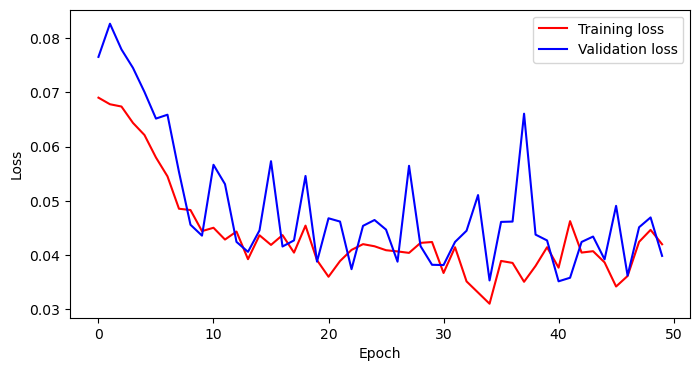

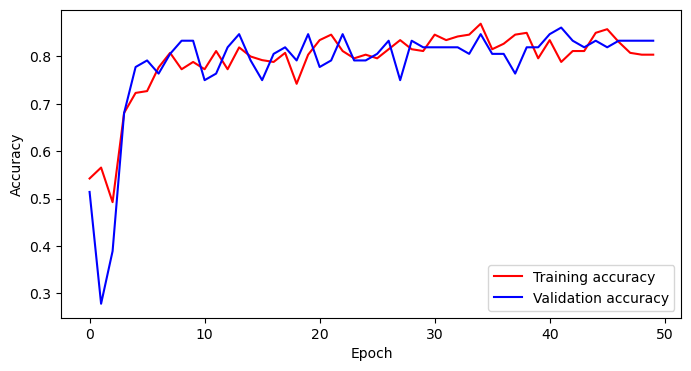

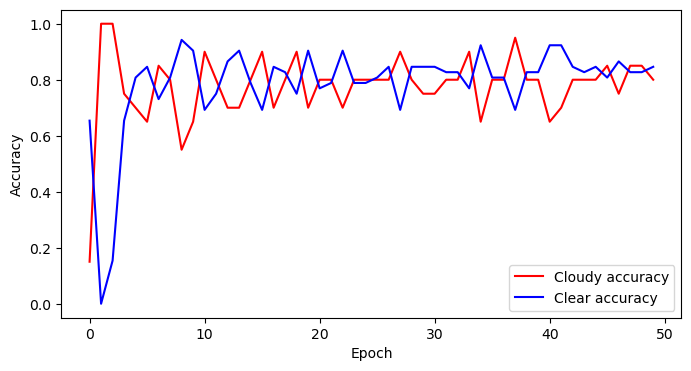

lowest loss for validation set: 0.03517805722852548, with an accuracy of 0.8472222222222222, cloud acc 0.65, clear acc = 0.9230769230769231


In [9]:
# Hyperparams. Set these to reasonable values
# TODO
LEARNING_RATE = 0.0001
EPOCHS = 50

# Load our network
model = Net()

# Define our loss function
#criterion = nn.CrossEntropyLoss()
criterion = nn.BCELoss()

# Define our optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
#optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Train the model
utils.train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=EPOCHS, cnn=True, sigmoid=True, show_log=True, show_plot=True)

### Results
| Parameter   | Value       | Value       | Value       |
| ----------- | ----------- | ----------- | ----------- |
| Loss Func   | BCE | BCE | BCE |
| Kernel Size | 5 | 5 | 5 |
| Optimization | Adam | Adam | SGD |
| Learning Rate | 0.0001 | 0.0001 | 0.0001 |
| Epochs | 50 | 50 | 50 |
| Normalization | yes | yes | yes |
| Bands used | 12 | 6 | 6 |
| Layers used | Sigmoid (12, 12, 5) | Sigmoid (6, 12, 5) | Sigmoid (6, 12, 5)Sigmoid + (12, 24, 5), (24, 48, 5) |
| Augmentation | yes | no | yes |
| Dropout | yes |yes | yes |
| **lowest loss** | 0.037427953340941005 | 0.03531379231976138 | 0.07600249350070953 |
| **best accuracy** | 0.8333333333333334 | 0.8611111111111112 | 0.7361111111111112 |
| **cloud accuracy** | 0.75 | 0.75 | 0.05 |
| **clear accuracy** | 0.8653846153846154 | 0.9038461538461539 | 1.0 |

### Results
| Parameter   | Value       | Value       | Value       |
| ----------- | ----------- | ----------- | ----------- |
| Loss Func   | CrossEntropy | CrossEntropy | CrossEntropy |
| Kernel Size | 5 | 5 | 5 |
| Optimization | Adam | Adam | Adam |
| Learning Rate | 0.0001 | 0.0001 | 0.0001 |
| Epochs | 30 | 30 | 50 |
| Normalization | yes | yes | yes |
| Bands used | 12 | 12 | 12 |
| Layers used | no Sigmoid | no Sigmoid | no Sigmoid |
| Augmentation | yes | yes | yes |
| Dropout | no | no | no |
| **lowest loss** | 0.039392199367284775 |  0.03988051083352831 |  0.03648176168402036 |
| **best accuracy** | 0.8611111111111112 |  0.8472222222222222 |  0.8472222222222222 |
| **cloud accuracy** | 0.5 | 0.45 |  0.7 |
| **clear accuracy** | 1.0 |  1.0 |  0.9038461538461539 |

### Results
| Parameter   | Value       | Value       | Value       |
| ----------- | ----------- | ----------- | ----------- |
| Loss Func   | CrossEntropy | CrossEntropy | CrossEntropy |
| Kernel Size | 5 | 5 | 5 |
| Optimization | Adam | Adam | Adam |
| Learning Rate | 0.0001 | 0.0001 | 0.0001 |
| Epochs | 50 | 50 | 50 |
| Normalization | no | yes | yes |
| Bands used | 12 | 12 | 12 |
| Layers used | no Sigmoid | Sigmoid | Sigmoid |
| Augmentation | yes | yes | yes |
| Dropout | yes | yes | yes |
| **lowest loss** | 0.03655324007074038 | 0.5493429601192474 | 0.5491726431581709 |
| **best accuracy** | 0.8333333333333334 | 0.8472222222222222 | 0.8472222222222222 |
| **cloud accuracy** | 0.75 | 0.8 | 0.75 |
| **clear accuracy** | 0.8653846153846154 | 0.8653846153846154 | 0.8846153846153846 |

### Results
| Parameter   | Value       | Value       | Value       |
| ----------- | ----------- | ----------- | ----------- |
| Loss Func   | CrossEntropy | CrossEntropy | BCE |
| Kernel Size | 5 | 5 | 5 |
| Optimization | Adam | Adam | Adam |
| Learning Rate | 0.0001 | scheduler | 0.0001 |
| Epochs | 50 | 50 | 50 |
| Normalization | yes | yes | yes |
| Bands used | 6 | 6 | 6 |
| Layers used | no Sigmoid | no Sigmoid | Sigmoid |
| Augmentation | yes | yes | yes |
| Dropout | yes |yes | yes |
| **lowest loss** | 0.039916380412048764 | 0.07377248836888207 | 0.03557943718300925 |
| **best accuracy** | 0.7916666666666666 | 0.7361111111111112 | 0.8611111111111112 |
| **cloud accuracy** | 0.7 | 0.05 | 0.8 |
| **clear accuracy** | 0.8269230769230769 | 1.0 | 0.8846153846153846 |

### Results
| Parameter   | Value       | Value       | Value       |
| ----------- | ----------- | ----------- | ----------- |
| Loss Func   | BCE | CrossEntropy | BCE |
| Kernel Size | 5 | 5 | 5 |
| Optimization | Adam | Adam | Adam |
| Learning Rate | 0.0001 | 0.0001 | 0.0001 |
| Epochs | 50 | 50 | 50 |
| Normalization | yes | yes | yes |
| Bands used | 6 | 6 | 12 |
| Layers used | Sigmoid + other layers | no Sigmoid + other layers | Sigmoid + (12, 24, 5), (24, 48, 5) |
| Augmentation | yes | yes | yes |
| Dropout | yes |yes | yes |
| **lowest loss** | 0.034954898059368134 | 0.03374983608308765 | 0.032706797329915896 |
| **best accuracy** | **0.8888888888888888** | 0.8611111111111112 | 0.8333333333333334 |
| **cloud accuracy** | 0.7 | 0.75 | 0.65 |
| **clear accuracy** | 0.9615384615384616 | 0.9038461538461539 | 0.9038461538461539 |

Final accuracy: 87.00%
Correct 87 times out of 100
Correct Clear 68 times out of 72: 94.44%
Correct Cloudy 19 times out of 28: 67.86%


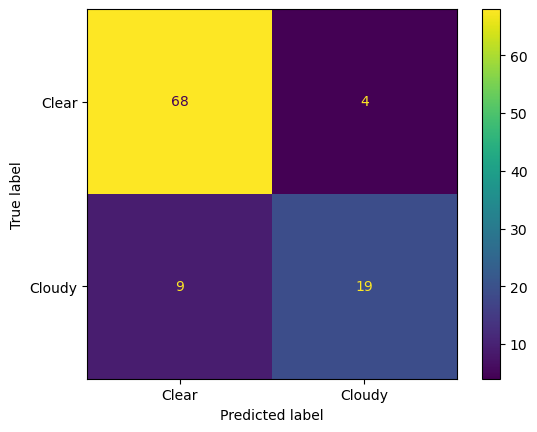

In [10]:
best_model = Net()
best_model = torch.load('best_cnn_model.pt')

utils.test_model(best_model, test_loader=test_loader, sigmoid=True, cnn=True)